In [ ]:
timport numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm

#Data Generating Assumptions of Linear Regression

We make several assumptions related to the generation of data used in linear regression models. A great deal of econometrics is dedicated to:
* assessing whether these assumptions hold in the data
* what to do if any assumptios do not hold
* deciding what assumptions are important in the context of our goals

##1 Linearity

The model should be linear in the parameters ($\beta$) and the error term ($\epsilon$). The model doesn't need to be linear in $X$'s and $Y$'s, e.g., the nonlinear transformations we've covered.

##2 Full rank

The columns of the $X$ matrix need to be linearly independent and there need to be at least as many observations as independent variables. In mathematical terms: $Rank(X) = k$.

This assumption often leads us to consider the trade-off between **multicollinearity** and **missing variable bias**

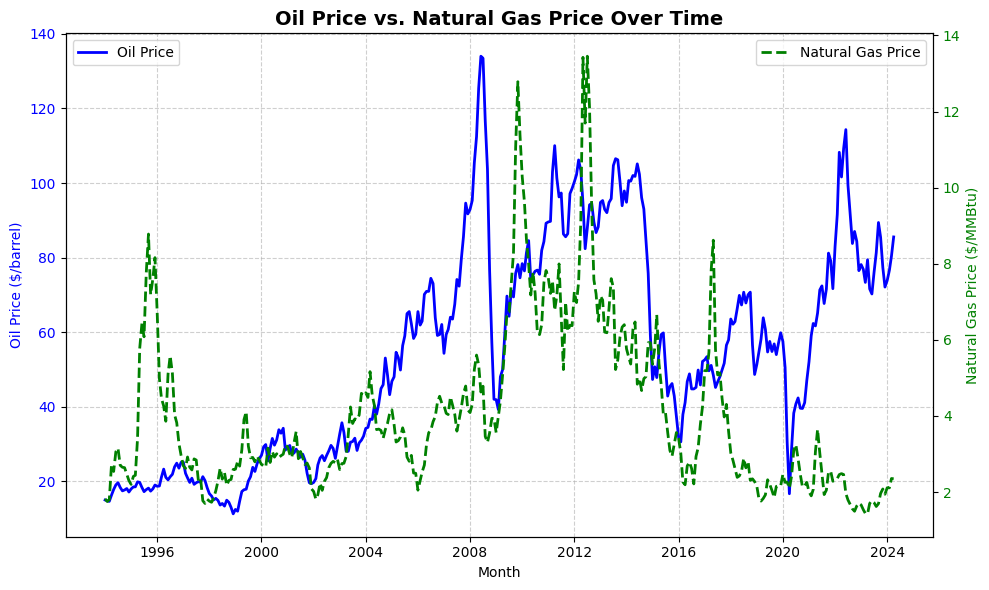

In [ ]:
# Load the CSV file into a pandas DataFrame
df_gas = pd.read_csv('oil gas price.csv')

# Convert 'month' to datetime format, 'month' is in 'MMM-YY' format (e.g., 'Jan-00')
# Use `errors='coerce'` to handle any invalid dates
df_gas['month'] = pd.to_datetime(df_gas['month'], format='%b-%y', errors='coerce')

# Drop rows with invalid dates (if any)
df_gas.dropna(subset=['month'], inplace=True)

# Set the 'month' column as the index (optional, for cleaner plotting)
df_gas.set_index('month', inplace=True)

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 'oil_price' on the primary y-axis
ax1.plot(df_gas.index, df_gas['oil_price'], color='blue', label='Oil Price', linewidth=2)
ax1.set_xlabel('Month')
ax1.set_ylabel('Oil Price ($/barrel)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for 'ng_price' (natural gas price)
ax2 = ax1.twinx()
ax2.plot(df_gas.index, df_gas['ng_price'], color='green', label='Natural Gas Price', linewidth=2, linestyle='--')
ax2.set_ylabel('Natural Gas Price ($/MMBtu)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Formatting the plot to make it look professional
plt.title('Oil Price vs. Natural Gas Price Over Time', fontsize=14, fontweight='bold')
fig.tight_layout()  # Adjust layout to make room for the second y-axis

# Add gridlines to the primary axis
ax1.grid(True, linestyle='--', alpha=0.6)

# Show the legend for both plots
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

##3 Mean Zero Errors

Conditional on $X$, the error terms are mean 0.

* In other words, $E(\epsilon|X) = 0$
* This implies that $E(Y|X) = X\beta$
* Including a constant term will guarantee this assumption holds

##4 Spherical Disrurbances (Errors)

The error terms should display **homoscedasticity** (i.e., error variances are constant across observations) and no **autocorrelation** (i.e., errors are uncorrelated across observations).

* Homoscedasticity: $Var[\epsilon_i] = \sigma^2$ for all $i = 1, 2,...,n$.
* No autocorrelation: $Cov[\epsilon_i, \epsilon_j] = 0$ for all $i \neq j$.
* Matrix representation:
\begin{multline}
Var[\epsilon] = E[\epsilon'\epsilon]
=
\begin{pmatrix}
Var[\epsilon_1] & Cov[\epsilon_2, \epsilon_1] & \dots &  Cov[\epsilon_n,\epsilon_1]\\
Cov[\epsilon_1, \epsilon_2] & Var[\epsilon_2] & \dots & Cov[\epsilon_n,\epsilon_2] \\
\vdots                       &    \vdots       &      & \vdots\\
Cov[\epsilon_1, \epsilon_n]  & Cov[\epsilon_2, \epsilon_n] & \dots & Var[\epsilon_n] \\
\end{pmatrix}\\
= \begin{pmatrix}
\sigma^2 & 0 & \dots &  0\\
0 & \sigma^2 & \dots & 0 \\
\vdots                       &    \vdots       &      & \vdots\\
0  & 0 & \dots & \sigma^2 \\
\end{pmatrix} = \sigma^2I_n
\end{multline}


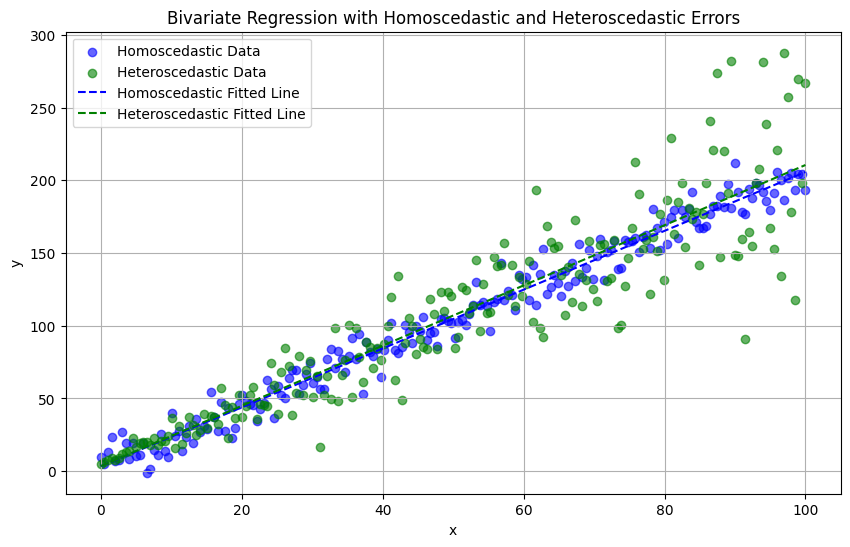

Homoscedastic model: Intercept = 3.4522522558935123, Slope = 2.0228007618477126, SE(Slope) = 0.022690549653089045
Heteroscedastic model: Intercept = 3.5080452935094257, Slope = 2.0704630571577263, SE(Slope) = 0.06678812696529297


In [ ]:
# Set seed for reproducibility
np.random.seed(42)

# Number of observations
n = 200

# Simulate independent variable (x) from a uniform distribution
x = np.linspace(0, 100, n)

# True intercept and slope
intercept = 5
slope = 2

# Homoscedastic errors (constant variance)
epsilon_homo = np.random.normal(0, 10, n)  # Constant error variance (10)

# Heteroscedastic errors (more extreme, variance increases with x)
epsilon_hetero = np.random.normal(0, 0.5 * x)  # Error variance increases more drastically with x

# Simulate dependent variable (y) with homoscedastic errors
y_homo = intercept + slope * x + epsilon_homo

# Simulate dependent variable (y) with heteroscedastic errors
y_hetero = intercept + slope * x + epsilon_hetero

# Create a DataFrame for both samples
df = pd.DataFrame({
    'x': x,
    'y_homo': y_homo,
    'y_hetero': y_hetero
})

# Fit linear regression for homoscedastic data
X = df[['x']]
X_homo = np.column_stack((np.ones(n), X))  # Add intercept term for matrix calculations
y_homo = df['y_homo']
model_homo = LinearRegression().fit(X, y_homo)
y_homo_pred = model_homo.predict(X)

# Fit linear regression for heteroscedastic data
y_hetero = df['y_hetero']
X_hetero = np.column_stack((np.ones(n), X))  # Add intercept term for matrix calculations
model_hetero = LinearRegression().fit(X, y_hetero)
y_hetero_pred = model_hetero.predict(X)

# Manual calculation of standard errors

# 1. Homoscedastic case
residuals_homo = y_homo - y_homo_pred
sigma_squared_homo = np.sum(residuals_homo ** 2) / (n - 2)  # Residual variance (n - 2 because two parameters: intercept and slope)
XtX_homo = X_homo.T @ X_homo
var_beta_homo = sigma_squared_homo * np.linalg.inv(XtX_homo)  # Variance-covariance matrix
se_slope_homo = np.sqrt(var_beta_homo[1, 1])  # Standard error of the slope

# 2. Heteroscedastic case
residuals_hetero = y_hetero - y_hetero_pred
sigma_squared_hetero = np.sum(residuals_hetero ** 2) / (n - 2)  # Residual variance
XtX_hetero = X_hetero.T @ X_hetero
var_beta_hetero = sigma_squared_hetero * np.linalg.inv(XtX_hetero)  # Variance-covariance matrix
se_slope_hetero = np.sqrt(var_beta_hetero[1, 1])  # Standard error of the slope

# Plotting the data on the same plot
plt.figure(figsize=(10, 6))

# Plot homoscedastic data
plt.scatter(x, y_homo, color='blue', alpha=0.6, label='Homoscedastic Data')

# Plot heteroscedastic data
plt.scatter(x, y_hetero, color='green', alpha=0.6, label='Heteroscedastic Data')

# Plot the fitted regression lines
plt.plot(x, y_homo_pred, color='blue', linestyle='--', label='Homoscedastic Fitted Line')
plt.plot(x, y_hetero_pred, color='green', linestyle='--', label='Heteroscedastic Fitted Line')

# Adding labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Bivariate Regression with Homoscedastic and Heteroscedastic Errors')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Print the estimated coefficients for both models with standard errors
print(f"Homoscedastic model: Intercept = {model_homo.intercept_}, Slope = {model_homo.coef_[0]}, SE(Slope) = {se_slope_homo}")
print(f"Heteroscedastic model: Intercept = {model_hetero.intercept_}, Slope = {model_hetero.coef_[0]}, SE(Slope) = {se_slope_hetero}")

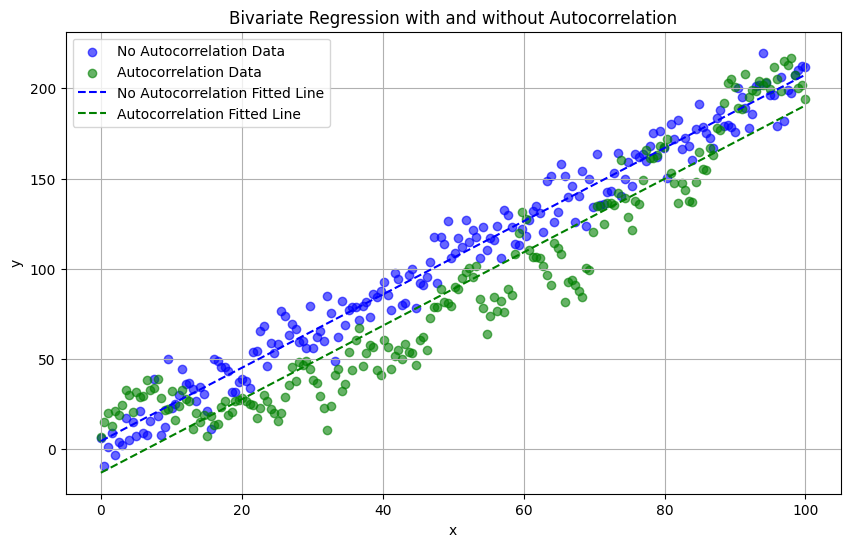

No Autocorrelation model: Intercept = 4.393244306557349, Slope = 2.0316799403527495
Autocorrelation model: Intercept = -13.141741443996565, Slope = 2.036830470427359


In [ ]:
# Set seed for reproducibility
np.random.seed(16)

# Number of observations
n = 200

# Simulate independent variable (x), a time-like variable
x = np.linspace(0, 100, n)

# True intercept and slope
intercept = 5
slope = 2

# Errors without autocorrelation (i.i.d. errors)
epsilon_no_auto = np.random.normal(0, 10, n)

# Errors with autocorrelation (AR(1) process)
rho = 0.95  # autocorrelation coefficient
epsilon_auto = np.zeros(n)
epsilon_auto[0] = np.random.normal(0, 10)  # First error
for t in range(1, n):
    epsilon_auto[t] = rho * epsilon_auto[t-1] + np.random.normal(0, 10)

# Simulate dependent variable (y) without autocorrelation
y_no_auto = intercept + slope * x + epsilon_no_auto

# Simulate dependent variable (y) with autocorrelation
y_auto = intercept + slope * x + epsilon_auto

# Create a DataFrame for both samples
df = pd.DataFrame({
    'x': x,
    'y_no_auto': y_no_auto,
    'y_auto': y_auto
})

# Fit linear regression for no autocorrelation data
X = df[['x']]
y_no_auto = df['y_no_auto']
model_no_auto = LinearRegression().fit(X, y_no_auto)
y_no_auto_pred = model_no_auto.predict(X)

# Fit linear regression for autocorrelation data
y_auto = df['y_auto']
model_auto = LinearRegression().fit(X, y_auto)
y_auto_pred = model_auto.predict(X)

# Plotting the data on the same plot
plt.figure(figsize=(10, 6))

# Plot no autocorrelation data
plt.scatter(x, y_no_auto, color='blue', alpha=0.6, label='No Autocorrelation Data')

# Plot autocorrelation data
plt.scatter(x, y_auto, color='green', alpha=0.6, label='Autocorrelation Data')

# Plot the fitted regression lines
plt.plot(x, y_no_auto_pred, color='blue', linestyle='--', label='No Autocorrelation Fitted Line')
plt.plot(x, y_auto_pred, color='green', linestyle='--', label='Autocorrelation Fitted Line')

# Adding labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Bivariate Regression with and without Autocorrelation')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Print the estimated coefficients for both models
print(f"No Autocorrelation model: Intercept = {model_no_auto.intercept_}, Slope = {model_no_auto.coef_[0]}")
print(f"Autocorrelation model: Intercept = {model_auto.intercept_}, Slope = {model_auto.coef_[0]}")

##5 Nonstochastic Regressors (Independent variables)
The independent variables are fixed in repeated samples.

* This is often true in scientific experiments
* This is often not true in observational data
* We can relax this assumption if $COV[X,\epsilon] = 0$
** How do we know if $COV[X,\epsilon] = 0$?

##6 Normality

 The error terms will follow a normal distribution. This assumption is supported by the Central Limit Theorem and is necessary for statistical inference. However, this assumption is not required to show the optimal properties of least squares estimators.

#Gauss-Markov Theorem

The **Gauss-Markov Theorem** states that the ordinary least squares (OLS) estimator $b$ is the minimum variance unbiased estimator among all linear unbiased estimators if the data-generating assumptions outlined above hold. Or, the OLS estimator is BLUE: Best Linear Unbiased Estimator.

Proof:

\begin{equation}
b = (X'X)^{-1}X'Y = (X'X)^{-1} X'(X\beta +\epsilon) = \beta + (X'X)^{-1}X'\epsilon
\end{equation}

Taking expectations gives:

\begin{equation}
E[b] = \beta + (X'X)^{-1} X'E[\epsilon] = \beta
\end{equation}

becasue neither $\beta$ nor $X$ are random (assumption that $X$ is fixed in repeated sampling). Therefore, $b$ is an unbiased estimator of $\beta$.

We now want to show that the estimator $b$ has a lower variance than all other unbiased linear estimators. Note that $b$ is a linear estimator because it is linear in $Y$ (see above). Consider all other potential linear estimators: $b_0 = CY$, where $C$ is a fixed ($k\times n$) matrix. In order for $b_0$ to be unbiased, it must be the case that $CX = I$:

\begin{equation}
E[b_0] = E[CY] = E[CX\beta + C\epsilon] = CX\beta = \beta
\end{equation}

if $CX = I$. The variance of the OLS estimator $b$ is

\begin{align}
VAR[b] &= E[(b-\beta)(b-\beta)']\\
       &= E[(X'X)^{-1}X'\epsilon \epsilon'X(X'X)^{-1}]\\
       &= (X'X)^{-1}X'\sigma^2I X(X'X)^{-1}\\
       &= \sigma^2(X'X)^{-1}.
\end{align}

The variance of $b_0$ is

\begin{align}
VAR[b_0] &= E[(b_0-\beta)(b_0-\beta)']\\
       &= E[C\epsilon \epsilon' C']\\
       &= \sigma^2 CC'.
\end{align}

So the only remaining question is whether $(X'X)^{-1}$ or $CC'$ is larger?

Let $D = C - (X'X)^{-1}X'$, then we can write

\begin{align}
VAR[b_0] &= \sigma^2(D + (X'X)^{-1}X')(D + X'X)^{-1}X')'\\
&= \sigma^2(X'X)^{-1} + \sigma^2DD'\\
&= VAR[b] + \sigma^2DD'
\end{align}

It can be shown that DD' is a non-negative definite matrix so $VAR[b_0]$ is at least as big as $VAR[b]$. Some things to note about the Gauss-Markov Theorem are:

* No distributional assumptions were neccesary.
* $b$ is a random variable with a sampling distribution
** $E[b] = \beta$ and $VAR[b] = \sigma^2(X'X)^{-1}$
* If $\epsilon|X \sim N(0,\sigma^2I)$ then $b \sim N(\beta, \sigma^2(X'X)^{-1})$ and the least squares estimator is best among all linear and non-linear estimators. For example, Maximum Likelihood estimators and OLS are equivalent in this case.
* An analyst might choose a biased estimator with a smaller MSE than OLS

#Statistical Inference in Least Squares Regressions

##Hypothesis Testing

We use assumption #6 from above in order to consider statistical inference in least squares. Assumption #6 requires $\epsilon \sim N(0,\sigma^2I)$. Since $b$ is a linear function of $\epsilon$, we can now write, $b \sim N(\beta, \sigma^2(X'X)^{-1})$ where $\sigma^2(X'X)^{-1}$ is the **standard error** of $b$. In most cases, we will not know $\sigma^2$ in advance and will use $s^2 = e'e/(n-k)$ to estimate $\sigma^2$.

Then we can use the test statistic
\begin{equation}
t_k = \frac{b_k - \beta_k}{s\sqrt{s^{kk}}}
\end{equation}
to perform hypothesis tests on the $k^{th}$ coefficient. $t_k$ has a Student's t distribution with $n-k$ degrees of freedom. $s = \sqrt{s^2}$ and $s^{kk}$ is the $k^{th}$ diagonal element of $(X'X)^{-1}$, i.e., the element associated with the $k^{th}$ independent variable.

##Confidence Intervals

The $(1-\lambda)*100$ confidence interval for $\beta_k$ can be found by noting that

$Pr(-t_{\lambda/2} < ((b_k-\beta_k)/s\sqrt{s^{kk}}) < t_{\lambda/2}) = 1 - \lambda$. Then rearranging, the confidence interval for $\beta_k$ is $[b_k - t_{\lambda/2}s\sqrt{s^{kk}}, b_k + t_{\lambda/2}s\sqrt{s^{kk}}]$.

Let's use the oil and gas data to make some of these calculations.

In [ ]:
# Extract the dependent and independent variables
Y = df_gas['ng_price'].values  # Dependent variable (natural gas price)
X = df_gas['oil_price'].values  # Independent variable (oil price)

# Add an intercept term to X (a column of ones for the intercept)
X = np.column_stack((np.ones(X.shape[0]), X))  # Adding intercept to X

# OLS Estimator: b = (X'X)^(-1) X'Y
XtX = X.T @ X  # X'X
XtY = X.T @ Y  # X'Y
beta_hat = np.linalg.inv(XtX) @ XtY  # OLS estimator

# Calculate residuals and variance of residuals
Y_hat = X @ beta_hat  # Predicted Y values
residuals = Y - Y_hat
n = len(Y)  # Number of observations
k = X.shape[1]  # Number of parameters (including intercept)
sigma_squared_hat = (residuals.T @ residuals) / (n - k)  # Residual variance (sigma^2)

# Calculate the variance-covariance matrix of the OLS estimator: Var(β̂) = σ̂² (X'X)^(-1)
var_beta_hat = sigma_squared_hat * np.linalg.inv(XtX)

# Standard errors of the coefficients
standard_errors = np.sqrt(np.diag(var_beta_hat))

# Calculate t-statistic for oil_price coefficient
t_stat_oil = beta_hat[1] / standard_errors[1]

# Calculate p-value for oil_price coefficient
p_value_oil = 2 * (1 - stats.t.cdf(np.abs(t_stat_oil), df=n - k))

# Calculate 95% confidence interval for oil_price coefficient
t_critical = stats.t.ppf(0.975, df=n - k)  # t-critical value for 95% confidence
margin_of_error = t_critical * standard_errors[1]
conf_interval_oil = (beta_hat[1] - margin_of_error, beta_hat[1] + margin_of_error)

# Print the results
print("OLS Coefficients (beta_hat):")
print(f"Intercept: {beta_hat[0]}")
print(f"Oil Price Coefficient: {beta_hat[1]}")
print("\nStandard Errors:")
print(f"Intercept: {standard_errors[0]}")
print(f"Oil Price Coefficient: {standard_errors[1]}")

# Print t-statistic, p-value, and 95% confidence interval for oil_price coefficient
print("\nT-Statistic for Oil Price Coefficient:")
print(f"t-statistic: {t_stat_oil}")

print("\nP-Value for Oil Price Coefficient:")
print(f"p-value: {p_value_oil}")

print("\n95% Confidence Interval for Oil Price Coefficient:")
print(f"Confidence Interval: {conf_interval_oil}")

print("\nRegression Summary:")
print(f"R-squared: {1 - (np.sum(residuals**2) / np.sum((Y - np.mean(Y))**2))}")
print(f"Residual Standard Error (sigma_hat): {np.sqrt(sigma_squared_hat)}")

OLS Coefficients (beta_hat):
Intercept: 2.4005189256484605
Oil Price Coefficient: 0.02938419500965839

Standard Errors:
Intercept: 0.22423977793994207
Oil Price Coefficient: 0.003631857888942713

T-Statistic for Oil Price Coefficient:
t-statistic: 8.090678630108119

P-Value for Oil Price Coefficient:
p-value: 9.103828801926284e-15

95% Confidence Interval for Oil Price Coefficient:
Confidence Interval: (0.022242005509532516, 0.036526384509784265)

Regression Summary:
R-squared: 0.15313531435372352
Residual Standard Error (sigma_hat): 2.0102406335653917


In [ ]:
# Extract the dependent and independent variables
Y = df_gas['ng_price'].values  # Dependent variable (natural gas price)
X = df_gas['oil_price'].values  # Independent variable (oil price)

# Reshape X to a 2D array for Scikit-Learn
X = X.reshape(-1, 1)

### 1. OLS Regression using Scikit-Learn ###
# Initialize and fit the linear regression model
model_sklearn = LinearRegression()
model_sklearn.fit(X, Y)

# Get the intercept and coefficient
intercept_sklearn = model_sklearn.intercept_
coef_sklearn = model_sklearn.coef_[0]

# Print Scikit-Learn results
print("Scikit-Learn Regression Results:")
print(f"Intercept: {intercept_sklearn}")
print(f"Oil Price Coefficient: {coef_sklearn}")
print(f"R-squared: {model_sklearn.score(X, Y)}")


### 2. OLS Regression using Statsmodels ###
# Add a constant (intercept) to X for Statsmodels
X_sm = sm.add_constant(X)

# Fit the OLS model
model_statsmodels = sm.OLS(Y, X_sm).fit()

# Print Statsmodels summary
print("\nStatsmodels Regression Results:")
print(model_statsmodels.summary())

Scikit-Learn Regression Results:
Intercept: 2.4005189256484636
Oil Price Coefficient: 0.02938419500965833
R-squared: 0.15313531435372374

Statsmodels Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     65.46
Date:                Fri, 20 Sep 2024   Prob (F-statistic):           9.07e-15
Time:                        10:48:08   Log-Likelihood:                -769.66
No. Observations:                 364   AIC:                             1543.
Df Residuals:                     362   BIC:                             1551.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err        